In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [93]:
data_path = '../../data/postprocessed/PM/'

mapping_table = {
    'NN50Perclenet5': 'LeNet5',
    'NN50PercLeNet5': 'LeNet5',
    'NN50Percmnasnet05': 'MnasNet',
    'NN50Percmobilenetv2': 'MobileNetV2',
    'NN50Percresnet18': 'ResNet18',
    'gpuburn5min': 'GPU-burn'
}

telemetry = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (file.endswith('_telemetry.csv') and ('NN50Perc' in file or '5min' in file))]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Index'] = range(len(df))
    df['progress'] = df['Index'].transform(
        lambda x: 100 * (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0)
    df['Range'] = int(csv_name.split('_')[1].split('_')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]

    telemetry=pd.concat([telemetry, df], ignore_index=True)

PC_profiling = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (('NN50Perc' in file or '5min' in file) and not 'telemetry' in file)]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    # print(df[df.isna()])
    PC_profiling=pd.concat([PC_profiling, df], ignore_index=True)

../../data/postprocessed/PM/NN50Perclenet5_1_telemetry.csv
../../data/postprocessed/PM/NN50Percmobilenetv2_1_telemetry.csv
../../data/postprocessed/PM/NN50Percresnet18_1_telemetry.csv
../../data/postprocessed/PM/gpuburn5min_1_telemetry.csv
../../data/postprocessed/PM/NN50Percmnasnet05_1_telemetry.csv
../../data/postprocessed/PM/NN50PercLeNet5_1.csv
../../data/postprocessed/PM/gpuburn5min_1.csv
../../data/postprocessed/PM/NN50Percresnet18_1.csv
../../data/postprocessed/PM/NN50Percmnasnet05_1.csv
../../data/postprocessed/PM/NN50Percmobilenetv2_1.csv


In [94]:
# Imposta come indice
PC_profiling['timestamp']=pd.to_datetime(PC_profiling['duration_ms'], yearfirst=True)
PC_profiling.set_index('timestamp', inplace=True)
PC_profiling\
    .groupby(by=[pd.Grouper(freq='1S'), 'App_name','location', 'metric_name'])\
        ['metric_value']\
            .mean()\
                .reset_index()

PC_agg_df = PC_profiling.sort_values(by=[
    'timestamp'
])

PC_agg_df['relative_second'] = PC_agg_df.groupby([
    'App_name', 'location', 'metric_name',
    'rollup_operation'
]).cumcount()

PC_agg_df['progress'] = PC_agg_df.groupby([
    'App_name', 'location', 'metric_name',
    'rollup_operation'
])['relative_second'].transform(
    lambda x: 100 * (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0
)

/tmp/ipykernel_78386/4100994835.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .groupby(by=[pd.Grouper(freq='1S'), 'App_name','location', 'metric_name'])\


## Select only a portion of the DataFrame

In [95]:
PC_df_portion = PC_agg_df[
        (PC_agg_df['progress'] >= 60) &
        (PC_agg_df['progress'] <= 80)
    ]
telemetry_df_portion = telemetry[
        (telemetry['progress'] >= 60) &
        (telemetry['progress'] <= 80)
    ]

In [96]:
location_mapping={
    'gpc': 'GPU Processing Cluster',
    'gr': 'Graphics Engine',
    'sm': 'Streaming Multiprocessor',
    'dramc': 'Dynamic RAM Controller',
    'pcie': 'PCI Express',
    'tpc': 'Texture Processing Cluster'
}
PC_df_portion['location'].unique()

PC_df_portion['HR_location'] = PC_df_portion['location'].map(location_mapping)

metric_event_mapping= {
    'cycles_elapsed': 'Total elapsed cycles [Cycles/s]',
    'cycles_active': 'Active cycles [Cycles/s]',
    'warps_active_realtime': 'Active warps [%]',
    'inst_executed': 'Executed instructions [%]',
    'ipe_tensor_cycles_active':'Tensor Cores Active Cycles [%]',
    'sectors_op_read':'Read Sectors [%]',
    'sectors_op_wtite':'Written Sectors [%]',
    'read_bytes':'Read bytes (CPU to GPU) [%]',
    'write_bytes':'Written bytes (GPU to CPU) [%]',
}
PC_df_portion['metric_name'].unique()

# pcie metrics are computed in a different way and it is better to keep them as a percentace
PC_df_portion = PC_df_portion[~((PC_df_portion['rollup_operation'] == 'sum') & (PC_df_portion['metric_name'] == 'read_bytes'))]

PC_df_portion = PC_df_portion.drop('rollup_operation', axis=1)

PC_df_portion['HR_metric_name'] = PC_df_portion['metric_name'].map(metric_event_mapping)

df_l2 = PC_df_portion[PC_df_portion['HR_location']=='GPU Processing Cluster']
df_sm = PC_df_portion[PC_df_portion['HR_location']=='Graphics Engine']
df_smsp = PC_df_portion[PC_df_portion['HR_location']=='Streaming Multiprocessor']
df_sys = PC_df_portion[PC_df_portion['HR_location']=='PCI Express']
df_dram = PC_df_portion[PC_df_portion['HR_location']=='Dynamic RAM Controller']

dfs = {
    'GPU Processing Cluster': df_l2, 
    'Graphics Engine': df_sm, 
    'Streaming Multiprocessor': df_smsp, 
    'PCI Express': df_sys, 
    'Dynamic RAM Controller': df_dram
    }

df_pivot_l2 = df_l2.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name", "progress"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm = df_sm.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name", "progress"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp = df_smsp.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name", "progress"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sys = df_sys.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name", "progress"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_dram = df_dram.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name", "progress"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'GPU Processing Cluster': df_pivot_l2, 
    'Graphics Engine': df_pivot_sm, 
    'Streaming Multiprocessor': df_pivot_smsp, 
    'PCI Express': df_pivot_sys, 
    'Dynamic RAM Controller': df_pivot_dram
    }

metric_full_name = PC_df_portion['HR_location'] +' '+ PC_df_portion['HR_metric_name']


/tmp/ipykernel_78386/183048088.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PC_df_portion['HR_location'] = PC_df_portion['location'].map(location_mapping)


/tmp/ipykernel_78386/3129752941.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_78386/3129752941.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_78386/3129752941.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_78386/3129752941.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykern

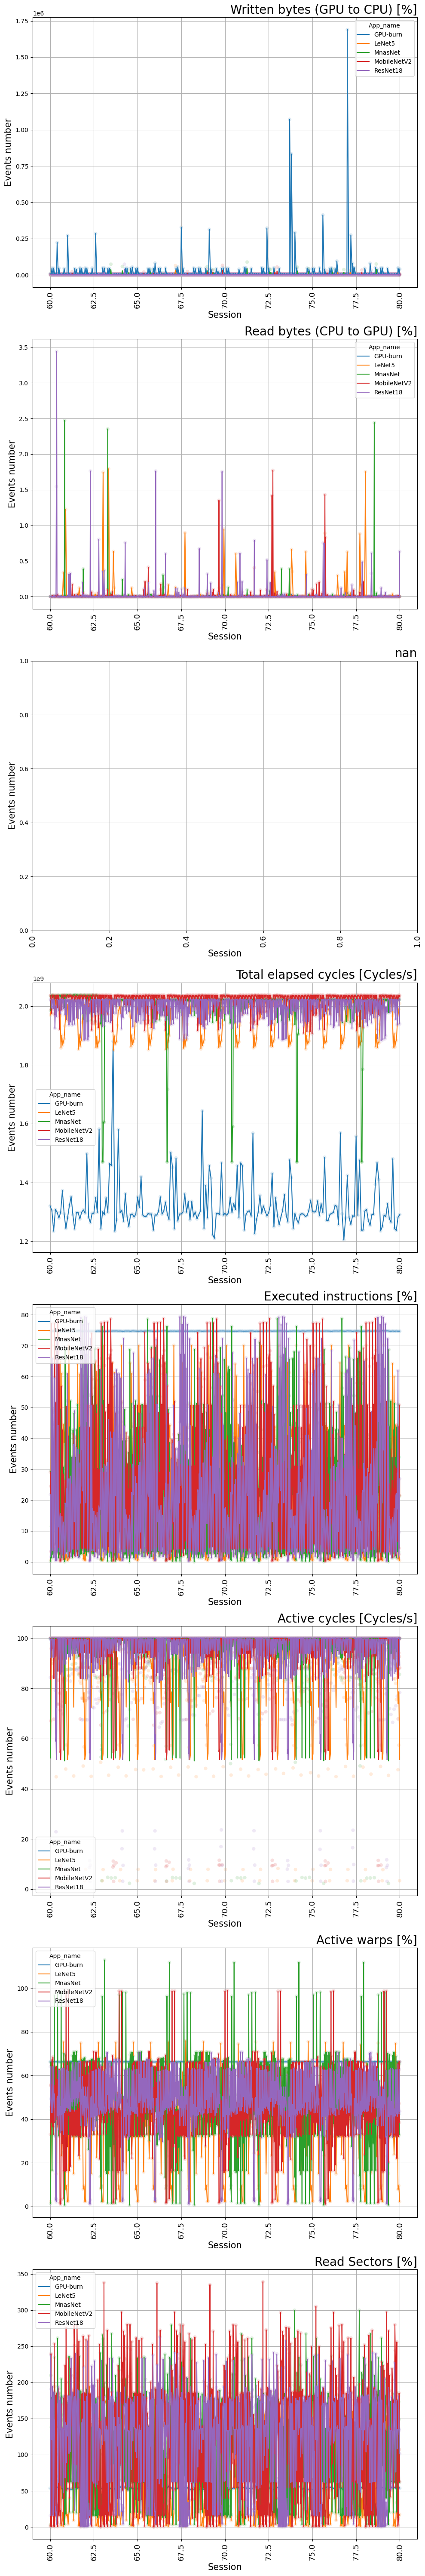

In [97]:
fig, ax = plt.subplots(8,1,figsize=(10,60))
for metric_idx in range(len(PC_df_portion['HR_metric_name'].unique())):
    metric_name = PC_df_portion['HR_metric_name'].unique()[metric_idx]
    data = PC_df_portion[PC_df_portion['HR_metric_name'] == metric_name]
    # HR_location=data['HR_location'].unique()[0]
    sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
    sns.scatterplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], alpha=0.15, legend=False)
    ax[metric_idx].set_title(f"{metric_name}", fontsize=20, loc='right')
    # ax[metric_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[metric_idx].transAxes,
    #      ha='left', va='top', fontsize=15)
    ax[metric_idx].grid()
    # ax[metric_idx].set_yscale('log')
    ax[metric_idx].set_xlabel('Session', fontsize=15)
    ax[metric_idx].set_ylabel('Events number', fontsize=15)
    ax[metric_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[df_idx].set_xticklabels([])
plt.tight_layout()

In [98]:
for df in pivot_dfs.values():
    print(len(df))

3611
3611
3611
3811
3611


In [99]:
PC_df_portion = PC_agg_df[
        (PC_agg_df['progress'] >= 60) &
        (PC_agg_df['progress'] <= 80)
    ]
telemetry_df_portion = telemetry[
        (telemetry['progress'] >= 60) &
        (telemetry['progress'] <= 80)
    ]

In [100]:
merged_dfs = {}
for key, PC_df in pivot_dfs.items():
    common_cols = set(PC_df.columns).intersection(telemetry_df_portion.columns) - {'progress'}

    telemetry_df_portion_reduced = telemetry_df_portion.drop(columns=common_cols)

    merged_df = pd.merge_asof(
        telemetry_df_portion_reduced.sort_values('progress'),
        PC_df.sort_values('progress'),
        on='progress',
        direction='nearest',
        tolerance=1.5
    )
    merged_dfs[key]=merged_df

In [101]:
merged_df['HR_location']

0       Dynamic RAM Controller
1       Dynamic RAM Controller
2       Dynamic RAM Controller
3       Dynamic RAM Controller
4       Dynamic RAM Controller
                 ...          
4815    Dynamic RAM Controller
4816    Dynamic RAM Controller
4817    Dynamic RAM Controller
4818    Dynamic RAM Controller
4819    Dynamic RAM Controller
Name: HR_location, Length: 4820, dtype: object

In [102]:
merged_df[merged_df['HR_location']=='Dynamic RAM Controller']['temperature_C']

0       46
1       46
2       46
3       46
4       46
        ..
4815    47
4816    47
4817    47
4818    47
4819    47
Name: temperature_C, Length: 4820, dtype: int64

GPU Processing Cluster


KeyError: 'App_name'

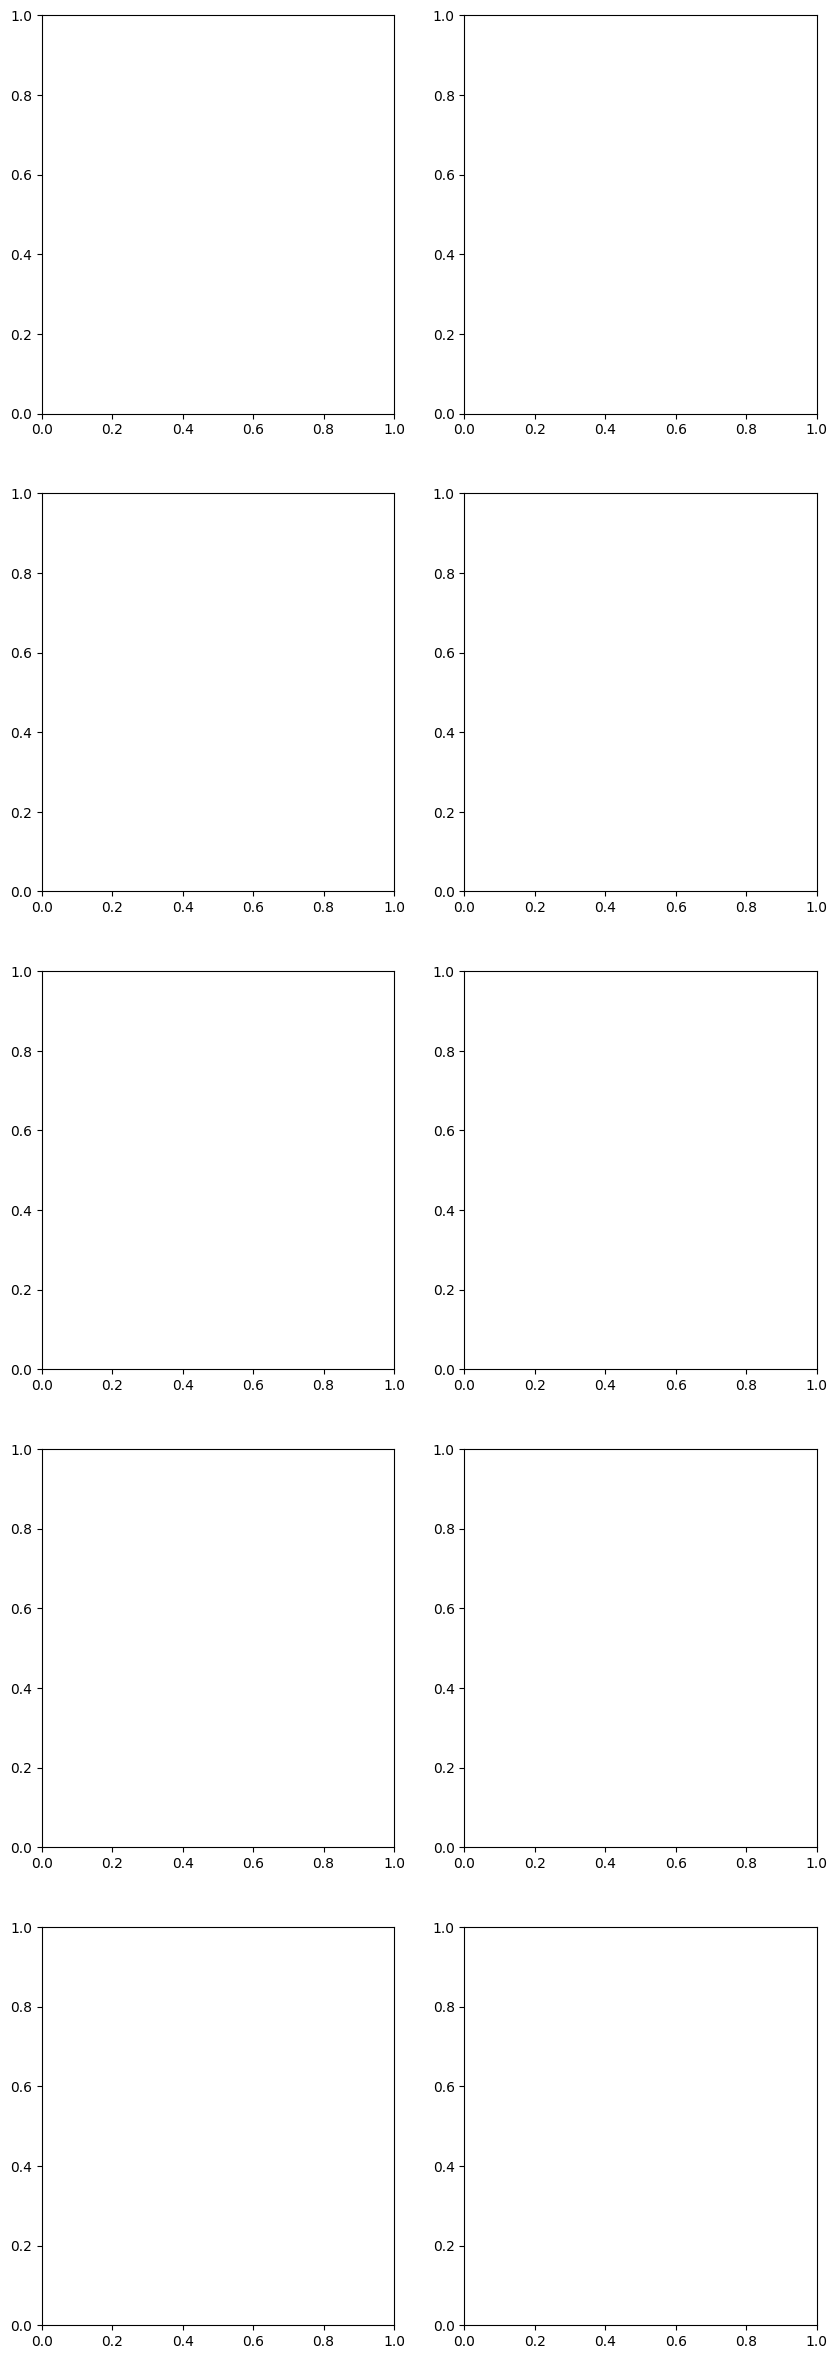

In [103]:
fig, ax = plt.subplots(5,2,figsize=(10,30))
for pivot_df_idx in range(len(list(merged_dfs.values()))):
    HR_location = list(merged_dfs.keys())[pivot_df_idx]
    print(HR_location)
    # print(merged_dfs[HR_location].select_dtypes(include=['float64']))
    # data_to_corr = merged_dfs[HR_location][cols_to_corr]
    # target_data = data_to_corr.drop('HR_location', axis = 1)
    data_to_corr = merged_dfs[merged_dfs['App_name']=='GPU-burn'][HR_location].select_dtypes(include=['float64', 'int64'])
    print(data_to_corr.columns)
    matrix = data_to_corr.corr()
    matrix.boxplot(ax=ax[pivot_df_idx][1])
    sns.heatmap(matrix, annot=False, cmap='coolwarm', ax=ax[pivot_df_idx][0])
    ax[pivot_df_idx][0].set_title(f"Grouped per: {HR_location}", fontsize=20, pad=40)
    ax[pivot_df_idx][0].grid()
    ax[pivot_df_idx][0].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][0].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][1].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].set_xticklabels([])
    ax[pivot_df_idx][1].set_xticklabels([])
    ax[pivot_df_idx][0].set_xlabel('')